In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! echo $PYTHONPATH

/env/python


In [3]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings

warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [6]:
ts = data['2018-03-30':'2018-09-29']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


In [20]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,5430.000000,5430.000000,5430.0,5430.000000,5430.00000
mean,290.070619,0.178206,0.0,44.658011,3296.05267
std,9.153027,0.748593,0.0,38.832373,1985.41250
min,259.650000,0.000000,0.0,0.000000,151.00000
25%,287.020000,0.000000,0.0,1.000000,1249.25000
50%,292.080000,0.000000,0.0,40.000000,3446.00000
75%,295.925000,0.000000,0.0,90.000000,4942.75000
max,310.070000,10.600000,0.0,92.000000,7213.00000


In [21]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [25]:
x_train = np.array(ts_train['traffic_volume'])
x_valid = np.array(ts_test['traffic_volume'])

time_train = np.array(ts_train['date_time'])
time_valid = np.array(ts_test['date_time'])


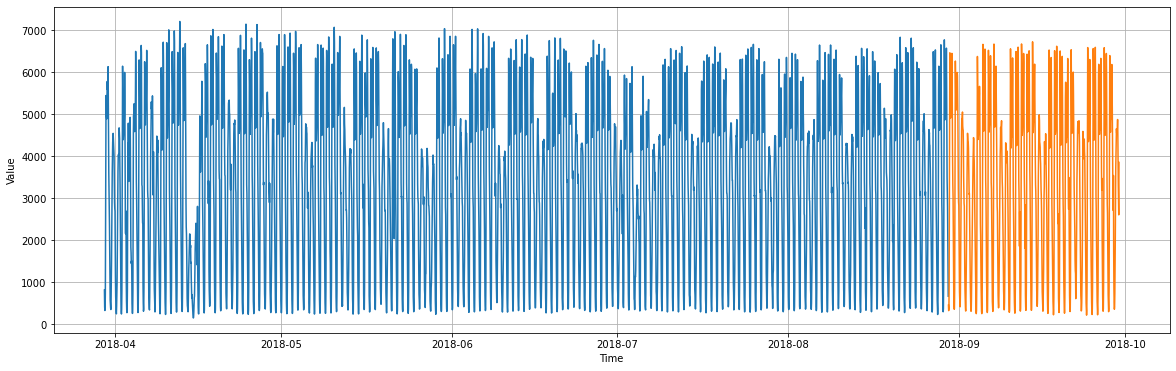

In [28]:
plt.figure(figsize=(20, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)


In [29]:
print(len(time_train))
print(len(x_train))
print(len(time_valid))
print(len(x_valid))

4462
4462
968
968


In [30]:
window_size = 24
batch_size = 32
shuffle_buffer_size = 1000

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [32]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 24
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))>
(4462,)


Epoch 1/300
18/18 [==============================] - 14s 41ms/step - loss: 2658.5620 - mae: 2659.0620 - lr: 1.0000e-08
Epoch 2/300
18/18 [==============================] - 1s 37ms/step - loss: 2180.5457 - mae: 2181.0459 - lr: 1.1220e-08
Epoch 3/300
18/18 [==============================] - 1s 36ms/step - loss: 1833.1180 - mae: 1833.6180 - lr: 1.2589e-08
Epoch 4/300
18/18 [==============================] - 1s 37ms/step - loss: 1615.3643 - mae: 1615.8640 - lr: 1.4125e-08
Epoch 5/300
18/18 [==============================] - 1s 38ms/step - loss: 1467.3978 - mae: 1467.8976 - lr: 1.5849e-08
Epoch 6/300
18/18 [==============================] - 1s 42ms/step - loss: 1325.5571 - mae: 1326.0571 - lr: 1.7783e-08
Epoch 7/300
18/18 [==============================] - 1s 41ms/step - loss: 1216.3636 - mae: 1216.8636 - lr: 1.9953e-08
Epoch 8/300
18/18 [==============================] - 1s 36ms/step - loss: 1132.9027 - mae: 1133.4025 - lr: 2.2387e-08
Epoch 9/300
18/18 [==============================] - 1s

18/18 [==============================] - 1s 36ms/step - loss: 1112.7440 - mae: 1113.2439 - lr: 2.8184e-05
Epoch 71/300
18/18 [==============================] - 1s 35ms/step - loss: 1194.3147 - mae: 1194.8147 - lr: 3.1623e-05
Epoch 72/300
18/18 [==============================] - 1s 34ms/step - loss: 1207.6027 - mae: 1208.1028 - lr: 3.5481e-05
Epoch 73/300
18/18 [==============================] - 1s 35ms/step - loss: 1259.8820 - mae: 1260.3817 - lr: 3.9811e-05
Epoch 74/300
18/18 [==============================] - 1s 36ms/step - loss: 1179.8634 - mae: 1180.3635 - lr: 4.4668e-05
Epoch 75/300
18/18 [==============================] - 1s 36ms/step - loss: 1406.1790 - mae: 1406.6787 - lr: 5.0119e-05
Epoch 76/300
18/18 [==============================] - 1s 35ms/step - loss: 1309.0488 - mae: 1309.5487 - lr: 5.6234e-05
Epoch 77/300
18/18 [==============================] - 1s 34ms/step - loss: 1381.2668 - mae: 1381.7670 - lr: 6.3096e-05
Epoch 78/300
18/18 [==============================] - 1s 34ms

18/18 [==============================] - 1s 36ms/step - loss: 2370879.0000 - mae: 2370879.5000 - lr: 0.0708
Epoch 139/300
18/18 [==============================] - 1s 36ms/step - loss: 2660666.5000 - mae: 2660667.0000 - lr: 0.0794
Epoch 140/300
18/18 [==============================] - 1s 36ms/step - loss: 2984796.5000 - mae: 2984797.0000 - lr: 0.0891
Epoch 141/300
18/18 [==============================] - 1s 36ms/step - loss: 3349509.2500 - mae: 3349510.0000 - lr: 0.1000
Epoch 142/300
18/18 [==============================] - 1s 36ms/step - loss: 3757723.0000 - mae: 3757723.2500 - lr: 0.1122
Epoch 143/300
18/18 [==============================] - 1s 38ms/step - loss: 4216716.0000 - mae: 4216717.0000 - lr: 0.1259
Epoch 144/300
18/18 [==============================] - 1s 36ms/step - loss: 4730729.5000 - mae: 4730730.0000 - lr: 0.1413
Epoch 145/300
18/18 [==============================] - 1s 35ms/step - loss: 5308466.5000 - mae: 5308467.0000 - lr: 0.1585
Epoch 146/300
18/18 [=================

18/18 [==============================] - 1s 37ms/step - loss: 4216487168.0000 - mae: 4216486400.0000 - lr: 125.8925
Epoch 204/300
18/18 [==============================] - 1s 36ms/step - loss: 4730975232.0000 - mae: 4730975232.0000 - lr: 141.2538
Epoch 205/300
18/18 [==============================] - 1s 36ms/step - loss: 5308243456.0000 - mae: 5308242432.0000 - lr: 158.4893
Epoch 206/300
18/18 [==============================] - 1s 35ms/step - loss: 5955945472.0000 - mae: 5955944960.0000 - lr: 177.8279
Epoch 207/300
18/18 [==============================] - 1s 37ms/step - loss: 6682681344.0000 - mae: 6682681856.0000 - lr: 199.5262
Epoch 208/300
18/18 [==============================] - 1s 39ms/step - loss: 7498091008.0000 - mae: 7498092032.0000 - lr: 223.8721
Epoch 209/300
18/18 [==============================] - 1s 36ms/step - loss: 8412998656.0000 - mae: 8412998656.0000 - lr: 251.1886
Epoch 210/300
18/18 [==============================] - 1s 36ms/step - loss: 9439536128.0000 - mae: 94395

18/18 [==============================] - 1s 35ms/step - loss: 4730974633984.0000 - mae: 4730974633984.0000 - lr: 141253.7500
Epoch 265/300
18/18 [==============================] - 1s 36ms/step - loss: 5308243509248.0000 - mae: 5308243509248.0000 - lr: 158489.3125
Epoch 266/300
18/18 [==============================] - 1s 35ms/step - loss: 5955944710144.0000 - mae: 5955944710144.0000 - lr: 177827.9375
Epoch 267/300
18/18 [==============================] - 1s 36ms/step - loss: 6682683375616.0000 - mae: 6682682851328.0000 - lr: 199526.2344
Epoch 268/300
18/18 [==============================] - 1s 35ms/step - loss: 7498089103360.0000 - mae: 7498090151936.0000 - lr: 223872.1094
Epoch 269/300
18/18 [==============================] - 1s 35ms/step - loss: 8412997877760.0000 - mae: 8412998402048.0000 - lr: 251188.6406
Epoch 270/300
18/18 [==============================] - 1s 35ms/step - loss: 9439537004544.0000 - mae: 9439537004544.0000 - lr: 281838.2812
Epoch 271/300
18/18 [====================

(1e-08, 0.0001, 0.0, 60.0)

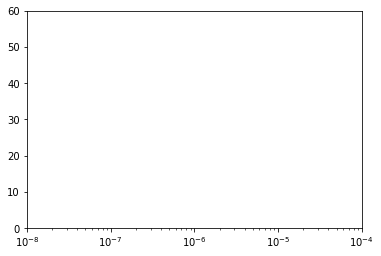

In [35]:
## tune learning rate

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 8000)

])
##
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
##
history = model.fit(train_set, epochs=300, callbacks=[lr_schedule])
##
plt.semilogx(history.history["lr"], history.history["loss"])

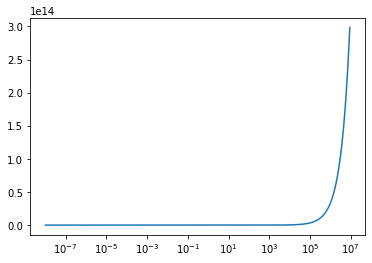

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])


In [38]:
tf.keras.backend.clear_session()

##
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1) #, kernel_regularizer=tf.keras.regularizers.L1(0.001)
    #tf.keras.layers.Lambda(lambda x: x * 8000)

])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [40]:
history = model.fit(train_set,validation_data=valid_set, epochs=300, callbacks=[es]) 

Epoch 1/300
35/35 [==============================] - 7s 67ms/step - loss: 3283.3579 - mae: 3283.8584 - val_loss: 3331.5291 - val_mae: 3332.0293
Epoch 2/300
35/35 [==============================] - 1s 30ms/step - loss: 3281.1064 - mae: 3281.6055 - val_loss: 3329.4602 - val_mae: 3329.9604
Epoch 3/300
35/35 [==============================] - 1s 29ms/step - loss: 3278.9954 - mae: 3279.4949 - val_loss: 3327.4033 - val_mae: 3327.9033
Epoch 4/300
35/35 [==============================] - 1s 29ms/step - loss: 3276.5994 - mae: 3277.0999 - val_loss: 3324.5312 - val_mae: 3325.0315
Epoch 5/300
35/35 [==============================] - 1s 30ms/step - loss: 3273.5764 - mae: 3274.0764 - val_loss: 3321.4043 - val_mae: 3321.9043
Epoch 6/300
35/35 [==============================] - 1s 29ms/step - loss: 3270.1785 - mae: 3270.6785 - val_loss: 3317.7893 - val_mae: 3318.2893
Epoch 7/300
35/35 [==============================] - 1s 29ms/step - loss: 3266.3818 - mae: 3266.8821 - val_loss: 3313.6589 - val_mae: 33

35/35 [==============================] - 1s 29ms/step - loss: 2624.3875 - mae: 2624.8875 - val_loss: 2668.4741 - val_mae: 2668.9736
Epoch 58/300
35/35 [==============================] - 1s 29ms/step - loss: 2607.8254 - mae: 2608.3250 - val_loss: 2652.1809 - val_mae: 2652.6809
Epoch 59/300
35/35 [==============================] - 1s 28ms/step - loss: 2591.6826 - mae: 2592.1821 - val_loss: 2636.2969 - val_mae: 2636.7966
Epoch 60/300
35/35 [==============================] - 1s 29ms/step - loss: 2575.5818 - mae: 2576.0820 - val_loss: 2620.5278 - val_mae: 2621.0278
Epoch 61/300
35/35 [==============================] - 1s 30ms/step - loss: 2557.7922 - mae: 2558.2922 - val_loss: 2600.6194 - val_mae: 2601.1194
Epoch 62/300
35/35 [==============================] - 1s 29ms/step - loss: 2540.1550 - mae: 2540.6550 - val_loss: 2584.5107 - val_mae: 2585.0107
Epoch 63/300
35/35 [==============================] - 1s 28ms/step - loss: 2523.1462 - mae: 2523.6460 - val_loss: 2565.0195 - val_mae: 2565.519

35/35 [==============================] - 1s 28ms/step - loss: 1340.9279 - mae: 1341.4274 - val_loss: 1353.9327 - val_mae: 1354.4323
Epoch 114/300
35/35 [==============================] - 1s 31ms/step - loss: 1317.8414 - mae: 1318.3409 - val_loss: 1327.9152 - val_mae: 1328.4147
Epoch 115/300
35/35 [==============================] - 1s 29ms/step - loss: 1293.9510 - mae: 1294.4510 - val_loss: 1303.7456 - val_mae: 1304.2454
Epoch 116/300
35/35 [==============================] - 1s 30ms/step - loss: 1270.9540 - mae: 1271.4535 - val_loss: 1280.4645 - val_mae: 1280.9642
Epoch 117/300
35/35 [==============================] - 1s 30ms/step - loss: 1245.3917 - mae: 1245.8914 - val_loss: 1254.0498 - val_mae: 1254.5496
Epoch 118/300
35/35 [==============================] - 1s 30ms/step - loss: 1220.7245 - mae: 1221.2242 - val_loss: 1226.0886 - val_mae: 1226.5881
Epoch 119/300
35/35 [==============================] - 1s 30ms/step - loss: 1194.3444 - mae: 1194.8441 - val_loss: 1200.2908 - val_mae: 12

35/35 [==============================] - 1s 29ms/step - loss: 401.2970 - mae: 401.7965 - val_loss: 328.5072 - val_mae: 329.0065
Epoch 171/300
35/35 [==============================] - 1s 28ms/step - loss: 395.3958 - mae: 395.8953 - val_loss: 322.4103 - val_mae: 322.9095
Epoch 172/300
35/35 [==============================] - 1s 28ms/step - loss: 392.2337 - mae: 392.7331 - val_loss: 318.3733 - val_mae: 318.8727
Epoch 173/300
35/35 [==============================] - 1s 29ms/step - loss: 385.1302 - mae: 385.6297 - val_loss: 314.0382 - val_mae: 314.5374
Epoch 174/300
35/35 [==============================] - 1s 28ms/step - loss: 380.4113 - mae: 380.9108 - val_loss: 310.7506 - val_mae: 311.2501
Epoch 175/300
35/35 [==============================] - 1s 28ms/step - loss: 376.2820 - mae: 376.7816 - val_loss: 308.0244 - val_mae: 308.5235
Epoch 176/300
35/35 [==============================] - 1s 29ms/step - loss: 368.5237 - mae: 369.0231 - val_loss: 311.7942 - val_mae: 312.2935
Epoch 177/300
35/35 

Epoch 228/300
35/35 [==============================] - 1s 29ms/step - loss: 267.8482 - mae: 268.3476 - val_loss: 163.2153 - val_mae: 163.7144
Epoch 229/300
35/35 [==============================] - 1s 29ms/step - loss: 267.8550 - mae: 268.3544 - val_loss: 182.8244 - val_mae: 183.3236
Epoch 230/300
35/35 [==============================] - 1s 28ms/step - loss: 268.6786 - mae: 269.1779 - val_loss: 167.0207 - val_mae: 167.5197
Epoch 231/300
35/35 [==============================] - 1s 29ms/step - loss: 264.8863 - mae: 265.3856 - val_loss: 155.8447 - val_mae: 156.3435
Epoch 232/300
35/35 [==============================] - 1s 30ms/step - loss: 265.2287 - mae: 265.7281 - val_loss: 175.1341 - val_mae: 175.6334
Epoch 233/300
35/35 [==============================] - 1s 30ms/step - loss: 265.8488 - mae: 266.3483 - val_loss: 166.4383 - val_mae: 166.9375
Epoch 234/300
35/35 [==============================] - 1s 29ms/step - loss: 265.1616 - mae: 265.6609 - val_loss: 149.2854 - val_mae: 149.7844
Epoch 

Epoch 286/300
35/35 [==============================] - 1s 31ms/step - loss: 240.3734 - mae: 240.8727 - val_loss: 124.5863 - val_mae: 125.0852
Epoch 287/300
35/35 [==============================] - 1s 28ms/step - loss: 241.5593 - mae: 242.0586 - val_loss: 127.9268 - val_mae: 128.4258
Epoch 288/300
35/35 [==============================] - 1s 29ms/step - loss: 245.5564 - mae: 246.0557 - val_loss: 132.9379 - val_mae: 133.4367
Epoch 289/300
35/35 [==============================] - 1s 29ms/step - loss: 241.6117 - mae: 242.1111 - val_loss: 126.9131 - val_mae: 127.4119
Epoch 290/300
35/35 [==============================] - 1s 31ms/step - loss: 242.8961 - mae: 243.3954 - val_loss: 154.1329 - val_mae: 154.6320
Epoch 290: early stopping


In [42]:
### summarize history for loss
split_time = 4462
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

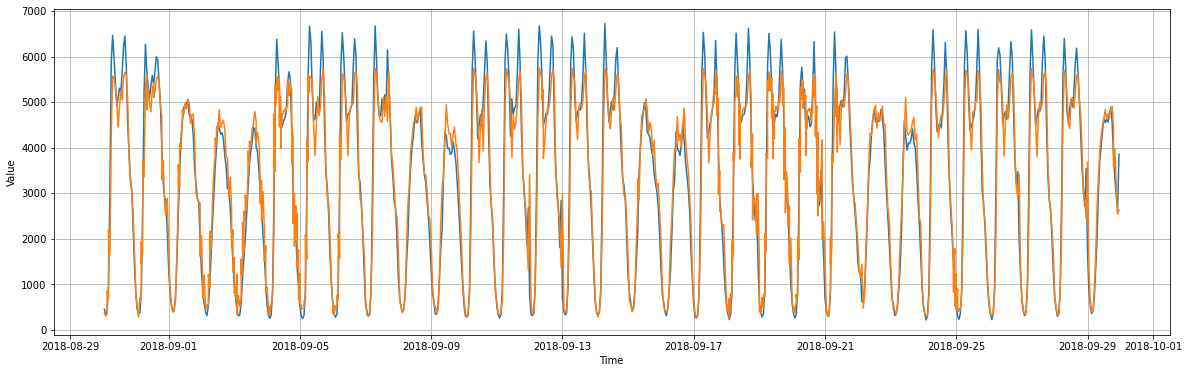

In [44]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [48]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

411.3838

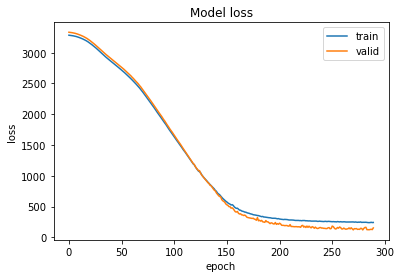

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


**Train test Split**

# LSTM

## Vanilla LSTM

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 8000)
])


In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=20, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [69]:
history = model.fit(train_set,validation_data=valid_set, epochs=300, callbacks=[es]) 

Epoch 1/300
35/35 [==============================] - 11s 97ms/step - loss: 1664.7463 - mae: 1665.2463 - val_loss: 1577.1577 - val_mae: 1577.6577
Epoch 2/300
35/35 [==============================] - 1s 35ms/step - loss: 1609.4496 - mae: 1609.9496 - val_loss: 1528.4708 - val_mae: 1528.9707
Epoch 3/300
35/35 [==============================] - 1s 35ms/step - loss: 1538.9536 - mae: 1539.4536 - val_loss: 1535.9659 - val_mae: 1536.4658
Epoch 4/300
35/35 [==============================] - 1s 35ms/step - loss: 1528.1073 - mae: 1528.6073 - val_loss: 1499.4280 - val_mae: 1499.9279
Epoch 5/300
35/35 [==============================] - 1s 35ms/step - loss: 1546.5728 - mae: 1547.0728 - val_loss: 1519.7980 - val_mae: 1520.2980
Epoch 6/300
35/35 [==============================] - 1s 35ms/step - loss: 1532.1165 - mae: 1532.6163 - val_loss: 1500.6587 - val_mae: 1501.1587
Epoch 7/300
35/35 [==============================] - 1s 35ms/step - loss: 1518.1256 - mae: 1518.6256 - val_loss: 1517.9282 - val_mae: 1

35/35 [==============================] - 1s 34ms/step - loss: 1516.4473 - mae: 1516.9471 - val_loss: 1493.4207 - val_mae: 1493.9204
Epoch 58/300
35/35 [==============================] - 1s 33ms/step - loss: 1508.7588 - mae: 1509.2587 - val_loss: 1491.0166 - val_mae: 1491.5165
Epoch 59/300
35/35 [==============================] - 1s 34ms/step - loss: 1509.9839 - mae: 1510.4838 - val_loss: 1490.7263 - val_mae: 1491.2263
Epoch 60/300
35/35 [==============================] - 1s 36ms/step - loss: 1506.6229 - mae: 1507.1229 - val_loss: 1504.0316 - val_mae: 1504.5315
Epoch 61/300
35/35 [==============================] - 1s 35ms/step - loss: 1515.9773 - mae: 1516.4773 - val_loss: 1498.3779 - val_mae: 1498.8779
Epoch 62/300
35/35 [==============================] - 1s 34ms/step - loss: 1507.6304 - mae: 1508.1304 - val_loss: 1486.2357 - val_mae: 1486.7357
Epoch 63/300
35/35 [==============================] - 1s 34ms/step - loss: 1504.9348 - mae: 1505.4348 - val_loss: 1493.3199 - val_mae: 1493.819

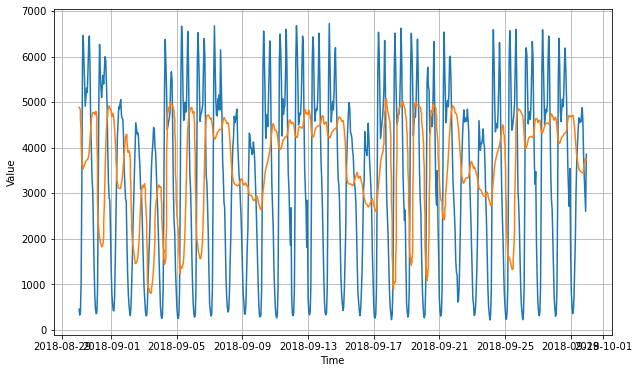

In [70]:
### summarize history for loss
split_time = 4462
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [71]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1945.2997

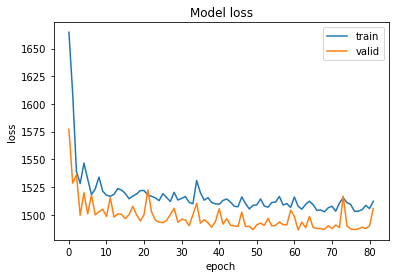

In [72]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
#from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers.convolutional import Conv1D
from tensorflow.keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import Dropout

ModuleNotFoundError: No module named 'tensorflow.keras.layers.convolutional'

In [0]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [78]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit lstm
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 5s 1ms/step - loss: 0.0746 - val_loss: 0.0311
Epoch 2/100
4438/4438 [==============================] - 1s 134us/step - loss: 0.0268 - val_loss: 0.0203
Epoch 3/100
4438/4438 [==============================] - 1s 128us/step - loss: 0.0200 - val_loss: 0.0157
Epoch 4/100
4438/4438 [==============================] - 1s 132us/step - loss: 0.0167 - val_loss: 0.0133
Epoch 5/100
4438/4438 [==============================] - 1s 128us/step - loss: 0.0143 - val_loss: 0.0113
Epoch 6/100
4438/4438 [==============================] - 1s 141us/step - loss: 0.0128 - val_loss: 0.0100
Epoch 7/100
4438/4438 [==============================] - 1s 137us/step - loss: 0.0117 - val_loss: 0.0092
Epoch 8/100
4438/4438 [==============================] - 1s 141us/step - loss: 0.0106 - val_loss: 0.0085
Epoch 9/100
4438/4438 [==============================] - 1s 137us/step - loss: 0.0101 - val_loss: 0.0080
Epoch 10/1

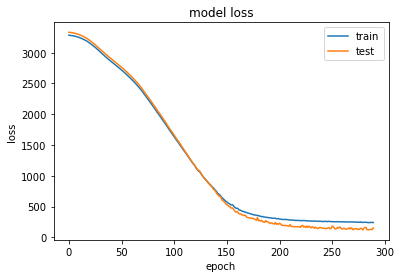

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [86]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 335.7626508499599
Train Root Mean Squared Error: 466.0101802844492
Test Mean Absolute percentage Error: 19.624351994073777
Test Mean Absolute Error: 364.4732391262843
Test Root Mean Squared Error: 513.8242004458365
Test Mean Absolute percentage Error: 22.254339962746677


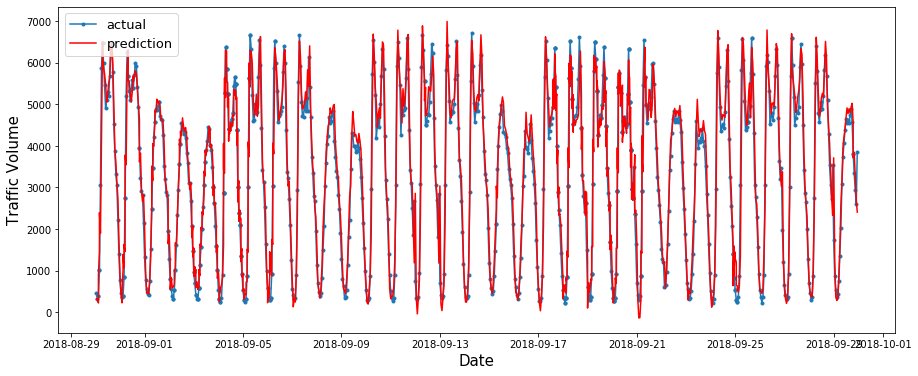

In [87]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

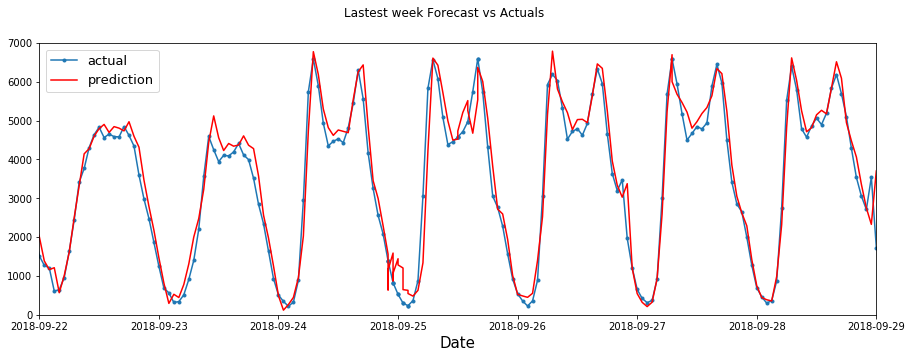

In [88]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Stacked LSTM

In [89]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 6s 1ms/step - loss: 0.0893 - val_loss: 0.0308
Epoch 2/100
4438/4438 [==============================] - 1s 211us/step - loss: 0.0275 - val_loss: 0.0192
Epoch 3/100
4438/4438 [==============================] - 1s 205us/step - loss: 0.0200 - val_loss: 0.0144
Epoch 4/100
4438/4438 [==============================] - 1s 208us/step - loss: 0.0164 - val_loss: 0.0115
Epoch 5/100
4438/4438 [==============================] - 1s 214us/step - loss: 0.0140 - val_loss: 0.0094
Epoch 6/100
4438/4438 [==============================] - 1s 229us/step - loss: 0.0124 - val_loss: 0.0082
Epoch 7/100
4438/4438 [==============================] - 1s 212us/step - loss: 0.0114 - val_loss: 0.0075
Epoch 8/100
4438/4438 [==============================] - 1s 208us/step - loss: 0.0103 - val_loss: 0.0070
Epoch 9/100
4438/4438 [==============================] - 1s 206us/step - loss: 0.0097 - val_loss: 0.0067
Epoch 10/1

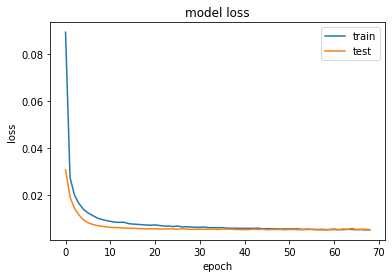

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [92]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 331.12612623822423
Train Root Mean Squared Error: 460.4774887054184
Test Mean Absolute percentage Error: 19.082845369848105
Test Mean Absolute Error: 364.4669128429791
Test Root Mean Squared Error: 513.8660917102951
Test Mean Absolute percentage Error: 21.941488704873148


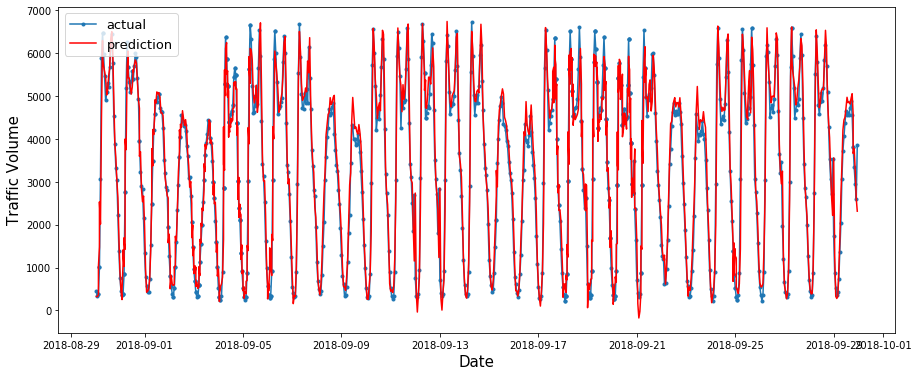

In [93]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

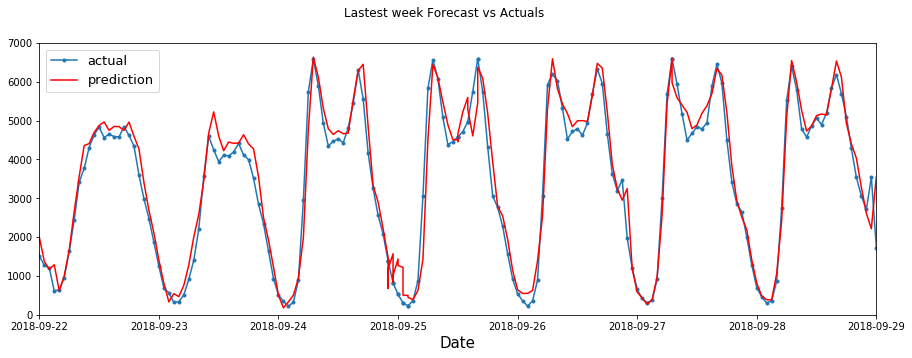

In [94]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Bidirectional LSTM 

In [95]:
model = Sequential()
model.add(Bidirectional(LSTM(64,activation='relu',), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 7s 2ms/step - loss: 0.0654 - val_loss: 0.0240
Epoch 2/100
4438/4438 [==============================] - 1s 207us/step - loss: 0.0210 - val_loss: 0.0152
Epoch 3/100
4438/4438 [==============================] - 1s 239us/step - loss: 0.0154 - val_loss: 0.0122
Epoch 4/100
4438/4438 [==============================] - 1s 232us/step - loss: 0.0129 - val_loss: 0.0104
Epoch 5/100
4438/4438 [==============================] - 1s 211us/step - loss: 0.0110 - val_loss: 0.0091
Epoch 6/100
4438/4438 [==============================] - 1s 215us/step - loss: 0.0097 - val_loss: 0.0076
Epoch 7/100
4438/4438 [==============================] - 1s 216us/step - loss: 0.0089 - val_loss: 0.0076
Epoch 8/100
4438/4438 [==============================] - 1s 215us/step - loss: 0.0082 - val_loss: 0.0074
Epoch 9/100
4438/4438 [==============================] - 1s 214us/step - loss: 0.0077 - val_loss: 0.0070
Epoch 10/1

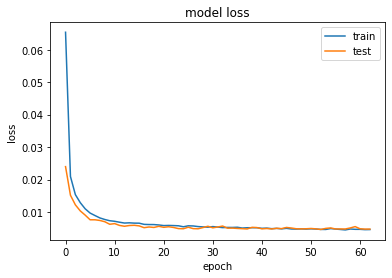

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [98]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 311.3892483154682
Train Root Mean Squared Error: 438.07519000035995
Test Mean Absolute percentage Error: 17.966212269002757
Test Mean Absolute Error: 343.455291905679
Test Root Mean Squared Error: 488.19913372588593
Test Mean Absolute percentage Error: 20.437379503219645


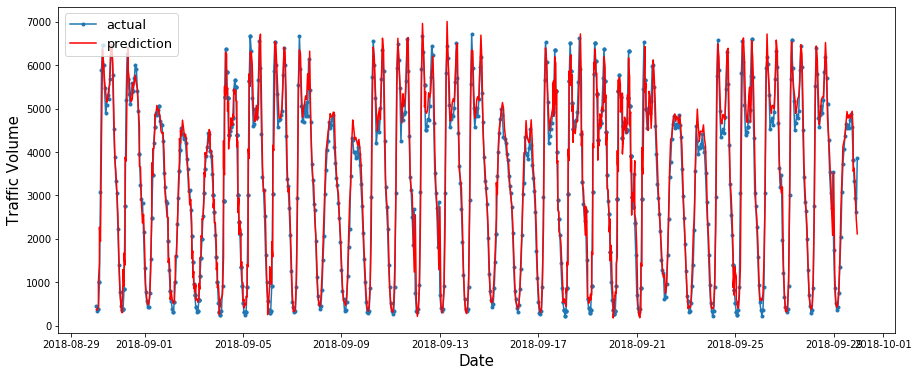

In [99]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

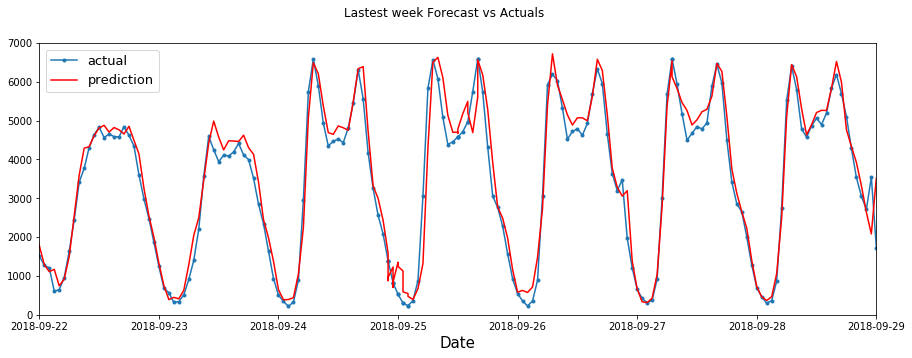

In [100]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')